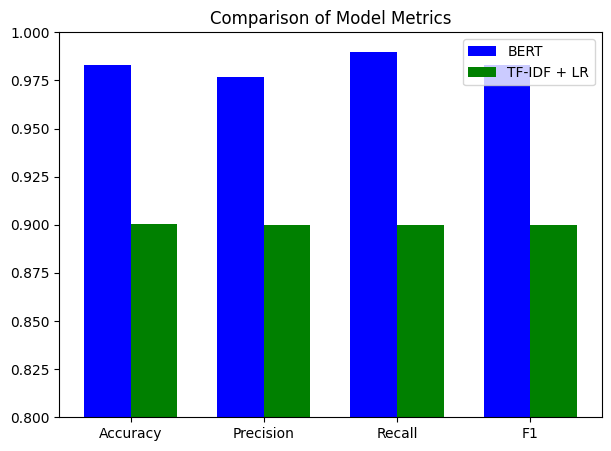

In [1]:
import matplotlib.pyplot as plt

# Example metrics (replace with your own)
bert_metrics = {
    "Accuracy": 0.983, 
    "Precision": 0.9766, 
    "Recall": 0.9896, 
    "F1": 0.9830
}
tfidf_metrics = {
    "Accuracy": 0.9003, 
    "Precision": 0.90, 
    "Recall": 0.90, 
    "F1": 0.90
}

metrics_labels = ["Accuracy", "Precision", "Recall", "F1"]
bert_scores = [bert_metrics[label] for label in metrics_labels]
tfidf_scores = [tfidf_metrics[label] for label in metrics_labels]

x = range(len(metrics_labels))
bar_width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x, bert_scores, width=bar_width, label="BERT", color="blue")
plt.bar([p + bar_width for p in x], tfidf_scores, width=bar_width, label="TF-IDF + LR", color="green")

plt.xticks([p + bar_width/2 for p in x], metrics_labels)
plt.ylim([0.80, 1.0])  # Adjust y-axis limit
plt.title("Comparison of Model Metrics")
plt.legend()
plt.show()

Processing text data with tokenization, lemmatization, and POS tagging...


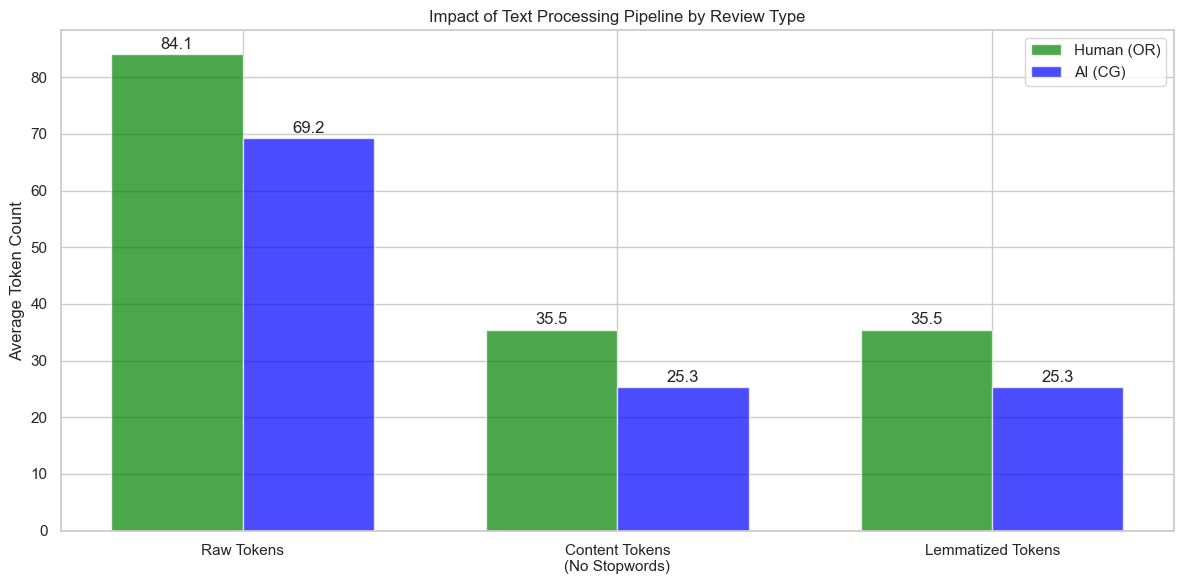

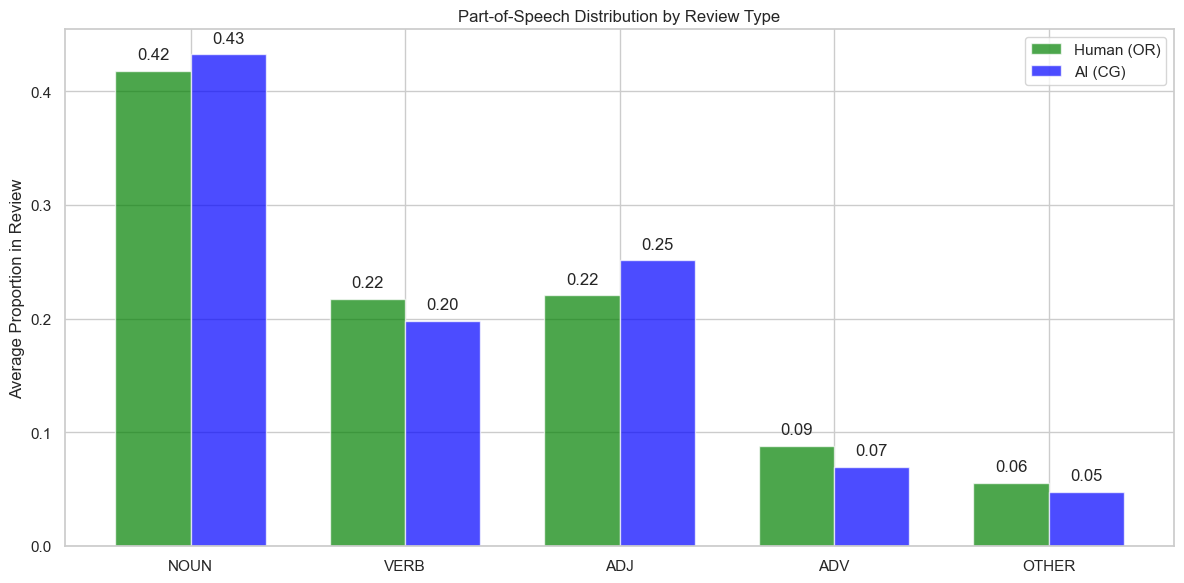

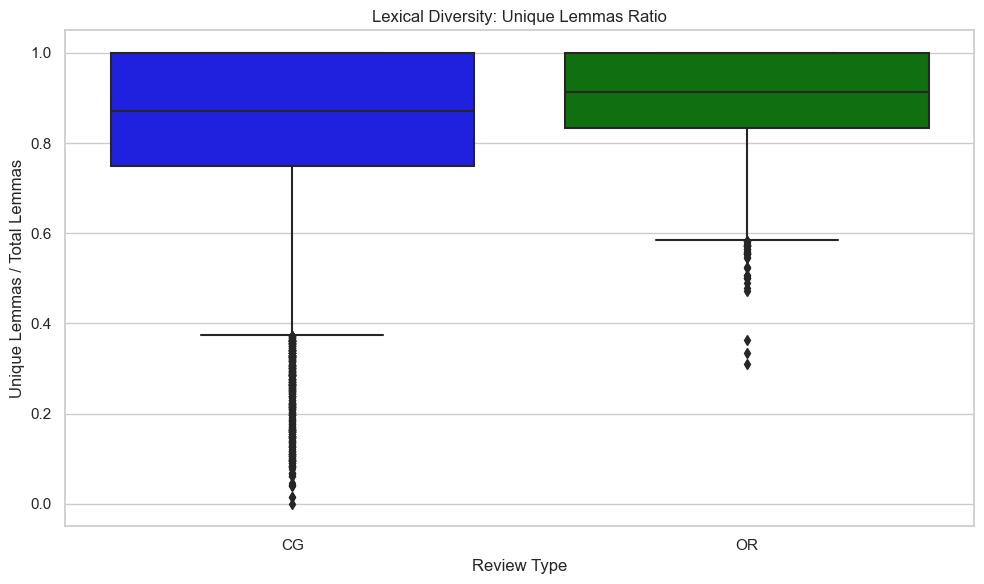

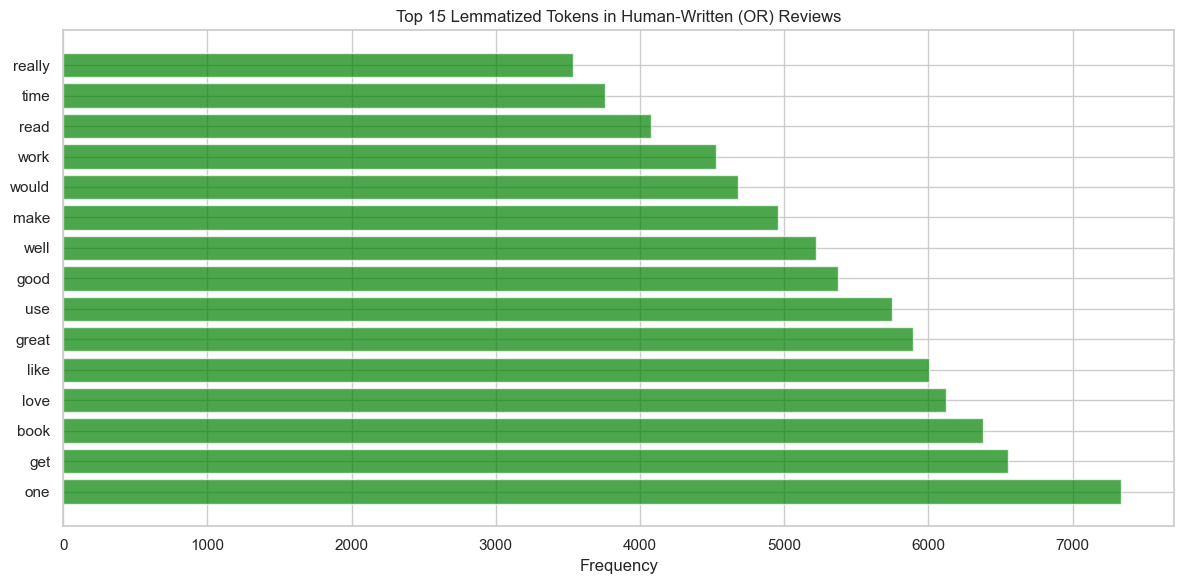

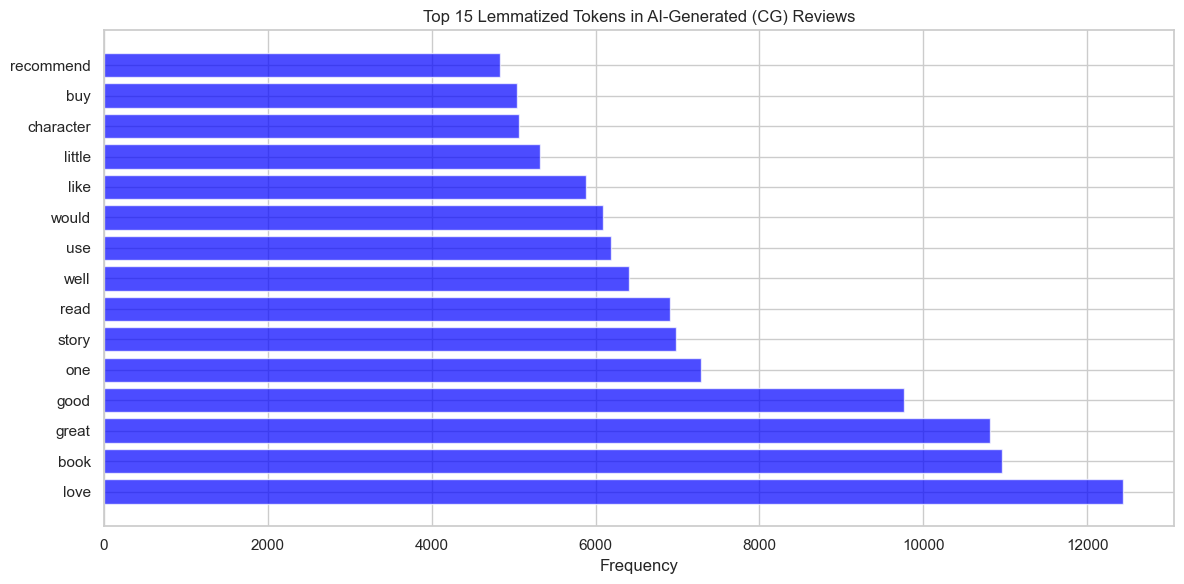

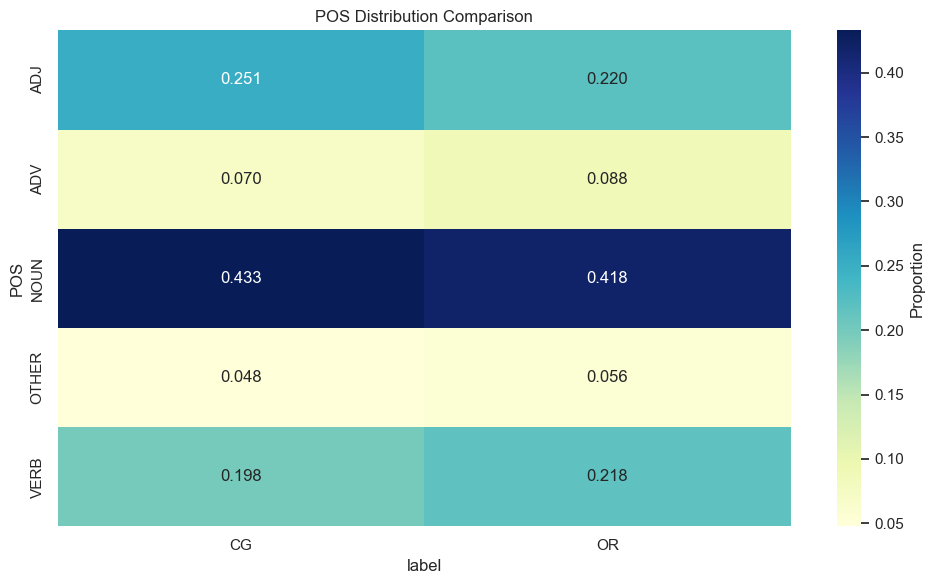

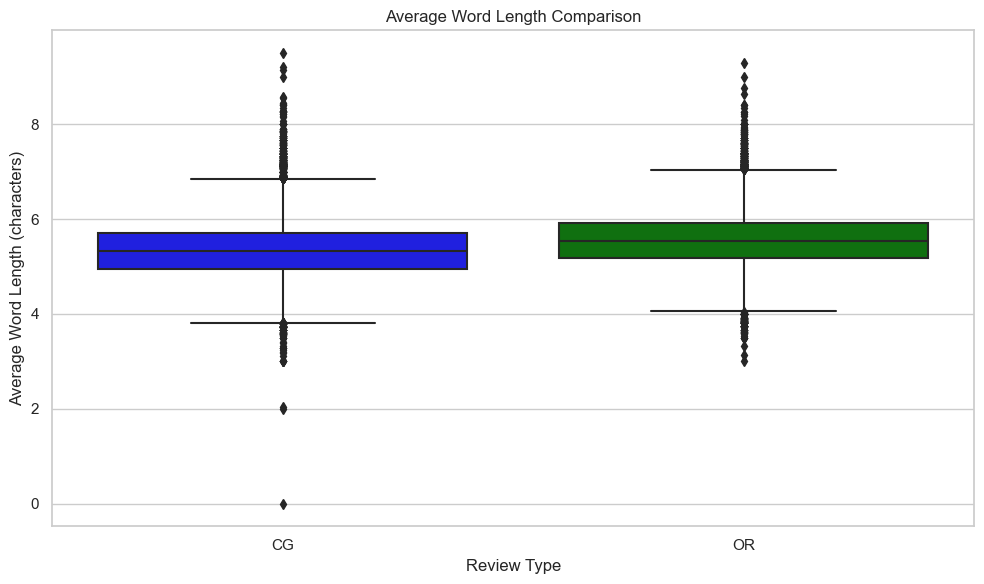


Language Structure Analysis Summary:

Average Text Processing Metrics:

CG Reviews:
  - Average raw token count: 69.18
  - Average content tokens (no stopwords): 25.27
  - Average lemmatized tokens: 25.27
  - Average stopword reduction: 62.41%
  - Average lexical diversity: 0.84
  - Average word length: 5.35 characters

  POS Distribution:
  - NOUN: 43.28%
  - VERB: 19.82%
  - ADJ: 25.14%
  - ADV: 6.98%
  - OTHER: 4.77%

OR Reviews:
  - Average raw token count: 84.05
  - Average content tokens (no stopwords): 35.47
  - Average lemmatized tokens: 35.47
  - Average stopword reduction: 56.74%
  - Average lexical diversity: 0.90
  - Average word length: 5.56 characters

  POS Distribution:
  - NOUN: 41.83%
  - VERB: 21.75%
  - ADJ: 22.04%
  - ADV: 8.83%
  - OTHER: 5.55%

Distinctive vocabulary in top-50 words:
  - Human-only: say, could, thing, find, know, two, take, even, need, much
  - AI-only: comfortable, dog, write, large, bit, quality, recommend, series, lot, enjoy


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download NLTK resources if needed
for resource in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']:
    nltk.download(resource, quiet=True)

# Load the dataset
csv_path = '/Users/ahmedmusayev/Desktop/VU/Year 2/P4/ML/MachineLearningProject/datasets/fake_reviews_dataset.csv'
df = pd.read_csv(csv_path, encoding="utf-8")

# Clean the data
df.dropna(subset=['text_'], inplace=True)

# Define stopwords set
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Tokenization function with POS tagging and lemmatization
def process_text(text):
    if isinstance(text, str):
        # Basic cleaning
        text = re.sub(r'http\S+', '', text)
        
        # Lowercase & tokenize
        tokens = word_tokenize(text.lower())
        
        # Keep only alphabetic tokens 
        alpha_tokens = [word for word in tokens if word.isalpha()]
        
        # Non-stopwords
        content_tokens = [word for word in alpha_tokens if word not in stop_words]
        
        # POS tagging
        tagged_tokens = nltk.pos_tag(content_tokens)
        
        # Lemmatize with POS information
        lemmatized_tokens = []
        pos_counts = Counter()  # To count POS tags
        
        for word, tag in tagged_tokens:
            # Convert Penn Treebank tags to WordNet POS tags
            if tag.startswith('J'):
                pos = 'a'  # adjective
                pos_type = 'ADJ'
            elif tag.startswith('V'):
                pos = 'v'  # verb
                pos_type = 'VERB'
            elif tag.startswith('N'):
                pos = 'n'  # noun
                pos_type = 'NOUN'
            elif tag.startswith('R'):
                pos = 'r'  # adverb
                pos_type = 'ADV'
            else:
                pos = 'n'  # default to noun
                pos_type = 'OTHER'
            
            # Lemmatize
            lemma = lemmatizer.lemmatize(word, pos=pos)
            lemmatized_tokens.append(lemma)
            
            # Count the POS
            pos_counts[pos_type] += 1
        
        return {
            'orig_tokens': tokens,
            'alpha_tokens': alpha_tokens,
            'content_tokens': content_tokens,
            'tagged_tokens': tagged_tokens,
            'lemmatized_tokens': lemmatized_tokens,
            'pos_counts': pos_counts,
            'token_count': len(tokens),
            'alpha_count': len(alpha_tokens),
            'content_count': len(content_tokens),
            'lemma_count': len(lemmatized_tokens)
        }
    return {}

# Process text for each review
print("Processing text data with tokenization, lemmatization, and POS tagging...")
df['processed'] = df['text_'].apply(process_text)

# Extract POS data
df['pos_counts'] = df['processed'].apply(lambda x: x.get('pos_counts', Counter()))
df['token_count'] = df['processed'].apply(lambda x: x.get('token_count', 0))
df['content_count'] = df['processed'].apply(lambda x: x.get('content_count', 0))
df['lemma_count'] = df['processed'].apply(lambda x: x.get('lemma_count', 0))

# Calculate text reduction metrics
df['stopwords_reduction'] = df.apply(lambda x: 1 - (x['content_count'] / x['token_count']) if x['token_count'] > 0 else 0, axis=1)
df['lemma_reduction'] = df.apply(lambda x: 1 - (x['lemma_count'] / x['content_count']) if x['content_count'] > 0 else 0, axis=1)

# Extract POS counts for each review
pos_categories = ['NOUN', 'VERB', 'ADJ', 'ADV', 'OTHER']
for pos in pos_categories:
    df[f'{pos}_count'] = df['pos_counts'].apply(lambda x: x.get(pos, 0))
    df[f'{pos}_ratio'] = df.apply(lambda x: x[f'{pos}_count'] / x['content_count'] if x['content_count'] > 0 else 0, axis=1)

# Set plot style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. Text Processing Pipeline Impact
# How much text is reduced in each processing step
processing_steps = ['token_count', 'content_count', 'lemma_count']
step_names = ['Raw Tokens', 'Content Tokens\n(No Stopwords)', 'Lemmatized Tokens']

# Calculate means for each class
or_means = [df[df['label'] == 'OR'][step].mean() for step in processing_steps]
cg_means = [df[df['label'] == 'CG'][step].mean() for step in processing_steps]

plt.figure(figsize=(12, 6))
x = np.arange(len(step_names))
width = 0.35

plt.bar(x - width/2, or_means, width, label='Human (OR)', color='green', alpha=0.7)
plt.bar(x + width/2, cg_means, width, label='AI (CG)', color='blue', alpha=0.7)

plt.ylabel('Average Token Count')
plt.title('Impact of Text Processing Pipeline by Review Type')
plt.xticks(x, step_names)
plt.legend()

for i, v in enumerate(or_means):
    plt.text(i - width/2, v + 1, f'{v:.1f}', ha='center')
for i, v in enumerate(cg_means):
    plt.text(i + width/2, v + 1, f'{v:.1f}', ha='center')

plt.tight_layout()
plt.show()

# 2. POS Distribution in Each Class
# Prepare data for POS distribution
pos_or = df[df['label'] == 'OR'][['NOUN_ratio', 'VERB_ratio', 'ADJ_ratio', 'ADV_ratio', 'OTHER_ratio']].mean()
pos_cg = df[df['label'] == 'CG'][['NOUN_ratio', 'VERB_ratio', 'ADJ_ratio', 'ADV_ratio', 'OTHER_ratio']].mean()

plt.figure(figsize=(12, 6))
x = np.arange(len(pos_categories))
width = 0.35

plt.bar(x - width/2, pos_or, width, label='Human (OR)', color='green', alpha=0.7)
plt.bar(x + width/2, pos_cg, width, label='AI (CG)', color='blue', alpha=0.7)

plt.ylabel('Average Proportion in Review')
plt.title('Part-of-Speech Distribution by Review Type')
plt.xticks(x, pos_categories)
plt.legend()

for i, v in enumerate(pos_or):
    plt.text(i - width/2, v + 0.01, f'{v:.2f}', ha='center')
for i, v in enumerate(pos_cg):
    plt.text(i + width/2, v + 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

# 3. Lexical Diversity: Unique Lemmas Ratio
# Extract unique lemmas for each review
df['unique_lemmas'] = df['processed'].apply(lambda x: len(set(x.get('lemmatized_tokens', []))))
df['lemma_diversity'] = df.apply(lambda x: x['unique_lemmas'] / x['lemma_count'] if x['lemma_count'] > 0 else 0, axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='lemma_diversity', data=df, palette={"OR": "green", "CG": "blue"})
plt.title('Lexical Diversity: Unique Lemmas Ratio')
plt.xlabel('Review Type')
plt.ylabel('Unique Lemmas / Total Lemmas')
plt.tight_layout()
plt.show()

# 4. Most Common Lemmatized Tokens by Class
# Get the most common lemmas for each class
or_lemmas = [lemma for tokens in df[df['label'] == 'OR']['processed'].apply(lambda x: x.get('lemmatized_tokens', [])) for lemma in tokens]
cg_lemmas = [lemma for tokens in df[df['label'] == 'CG']['processed'].apply(lambda x: x.get('lemmatized_tokens', [])) for lemma in tokens]

or_common = Counter(or_lemmas).most_common(15)
cg_common = Counter(cg_lemmas).most_common(15)

# Plot Human (OR) common lemmas
plt.figure(figsize=(12, 6))
words, counts = zip(*or_common)
plt.barh(range(len(words)), counts, color='green', alpha=0.7)
plt.yticks(range(len(words)), words)
plt.title('Top 15 Lemmatized Tokens in Human-Written (OR) Reviews')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

# Plot AI (CG) common lemmas
plt.figure(figsize=(12, 6))
words, counts = zip(*cg_common)
plt.barh(range(len(words)), counts, color='blue', alpha=0.7)
plt.yticks(range(len(words)), words)
plt.title('Top 15 Lemmatized Tokens in AI-Generated (CG) Reviews')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

# 5. Comparative POS Heatmap
pos_data = df.groupby('label')[['NOUN_ratio', 'VERB_ratio', 'ADJ_ratio', 'ADV_ratio', 'OTHER_ratio']].mean().reset_index()
pos_data = pos_data.melt(id_vars='label', var_name='POS', value_name='Ratio')
pos_data['POS'] = pos_data['POS'].str.replace('_ratio', '')

plt.figure(figsize=(10, 6))
heatmap_data = pos_data.pivot(index='POS', columns='label', values='Ratio')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', cbar_kws={'label': 'Proportion'})
plt.title('POS Distribution Comparison')
plt.tight_layout()
plt.show()

# 6. Advanced Language Complexity Metrics
# Calculate average word length
df['avg_word_length'] = df['processed'].apply(lambda x: np.mean([len(token) for token in x.get('content_tokens', [''])]) if x.get('content_tokens') else 0)

# Visualize word length comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='avg_word_length', data=df, palette={"OR": "green", "CG": "blue"})
plt.title('Average Word Length Comparison')
plt.xlabel('Review Type')
plt.ylabel('Average Word Length (characters)')
plt.tight_layout()
plt.show()

# Summarize findings
print("\nLanguage Structure Analysis Summary:")
print("===================================")

print("\nAverage Text Processing Metrics:")
for label, group in df.groupby('label'):
    print(f"\n{label} Reviews:")
    print(f"  - Average raw token count: {group['token_count'].mean():.2f}")
    print(f"  - Average content tokens (no stopwords): {group['content_count'].mean():.2f}")
    print(f"  - Average lemmatized tokens: {group['lemma_count'].mean():.2f}")
    print(f"  - Average stopword reduction: {group['stopwords_reduction'].mean()*100:.2f}%")
    print(f"  - Average lexical diversity: {group['lemma_diversity'].mean():.2f}")
    print(f"  - Average word length: {group['avg_word_length'].mean():.2f} characters")
    
    print("\n  POS Distribution:")
    for pos in pos_categories:
        print(f"  - {pos}: {group[f'{pos}_ratio'].mean()*100:.2f}%")

# Output linguistic pattern insights
human_distinctive = set([w for w, _ in Counter(or_lemmas).most_common(50)]) - set([w for w, _ in Counter(cg_lemmas).most_common(50)])
ai_distinctive = set([w for w, _ in Counter(cg_lemmas).most_common(50)]) - set([w for w, _ in Counter(or_lemmas).most_common(50)])

print("\nDistinctive vocabulary in top-50 words:")
print(f"  - Human-only: {', '.join(list(human_distinctive)[:10])}")
print(f"  - AI-only: {', '.join(list(ai_distinctive)[:10])}")

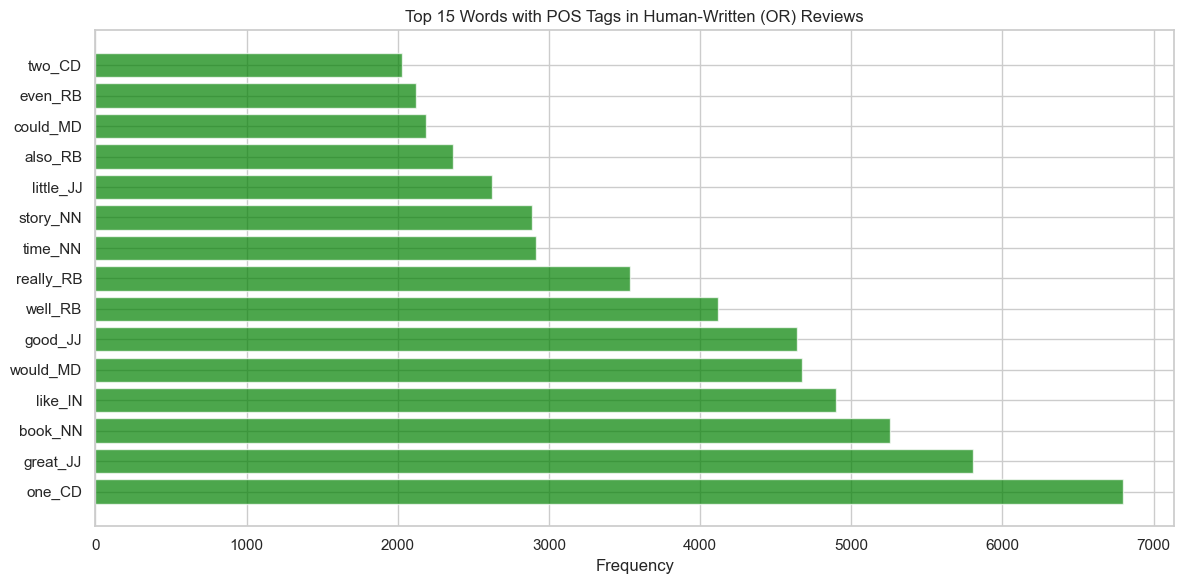


Graph Explanation - Top Human Words:
This graph shows the most common words in human-written reviews, with their part-of-speech tags. 
The tags use the Penn Treebank format where NN = noun, JJ = adjective, VB/VBD/VBP = verb forms, 
and RB = adverb. Human reviews tend to contain more personal pronouns (PRP) and varied vocabulary.
The frequency distribution shows which words humans commonly use when writing authentic reviews,
often including more specific descriptors and emotional content.



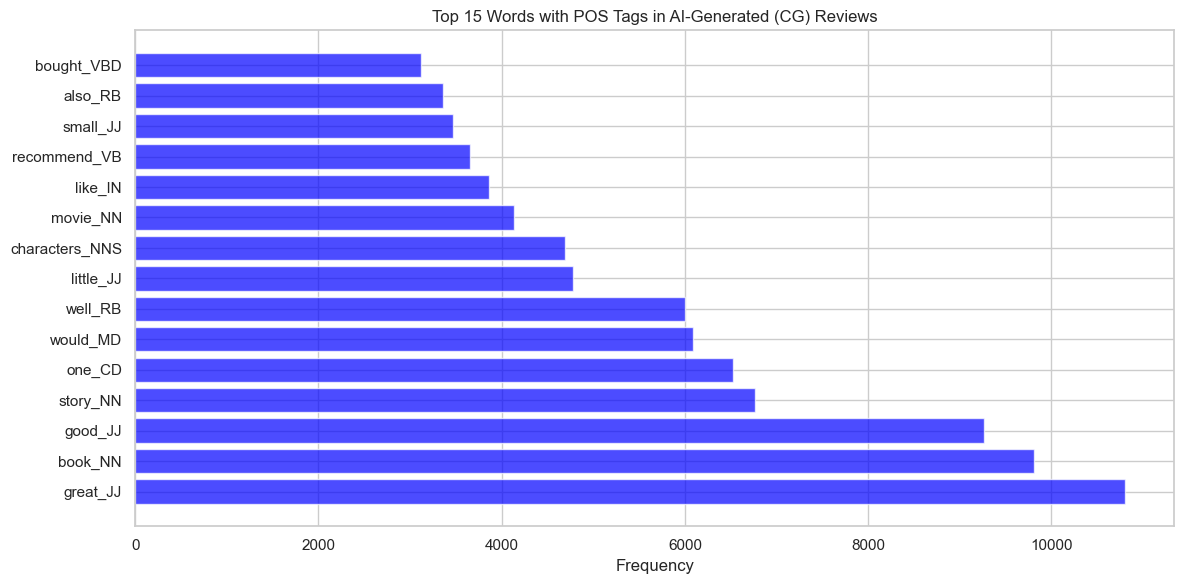


Graph Explanation - Top AI Words:
This visualization reveals the most frequent words in AI-generated reviews with their grammatical roles.
AI tends to use more formulaic language patterns and common descriptive words (JJ tags for adjectives).
The different distribution compared to human reviews highlights how AI language models have patterns
in word choice and grammatical structure that distinguish them from human writing styles.


Graph Explanation - Text Processing Pipeline:
This graph compares the average token counts at each stage of text processing between human and AI reviews.
Raw tokens represent all words, content tokens exclude stopwords, and lemmatized tokens group word forms.
The difference between human and AI patterns shows how text length and complexity vary by source.
A significant drop from raw tokens to content tokens indicates heavy reliance on stopwords,
while minimal change from content tokens to lemmatized tokens suggests more diverse vocabulary usage.


Graph Exp

In [12]:
# 4. Most Common Lemmatized Tokens by Class with POS Tags
# Get the most common lemmas with their POS tags for each class
or_lemmas_pos = [f"{word}_{tag}" for tokens in df[df['label'] == 'OR']['processed'].apply(
    lambda x: x.get('tagged_tokens', [])) for word, tag in tokens]
cg_lemmas_pos = [f"{word}_{tag}" for tokens in df[df['label'] == 'CG']['processed'].apply(
    lambda x: x.get('tagged_tokens', [])) for word, tag in tokens]

or_common_pos = Counter(or_lemmas_pos).most_common(15)
cg_common_pos = Counter(cg_lemmas_pos).most_common(15)

# Plot Human (OR) common lemmas with POS tags
plt.figure(figsize=(12, 6))
words_pos, counts = zip(*or_common_pos)
plt.barh(range(len(words_pos)), counts, color='green', alpha=0.7)
plt.yticks(range(len(words_pos)), words_pos)
plt.title('Top 15 Words with POS Tags in Human-Written (OR) Reviews')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

print("""
Graph Explanation - Top Human Words:
This graph shows the most common words in human-written reviews, with their part-of-speech tags. 
The tags use the Penn Treebank format where NN = noun, JJ = adjective, VB/VBD/VBP = verb forms, 
and RB = adverb. Human reviews tend to contain more personal pronouns (PRP) and varied vocabulary.
The frequency distribution shows which words humans commonly use when writing authentic reviews,
often including more specific descriptors and emotional content.
""")

# Plot AI (CG) common lemmas with POS tags
plt.figure(figsize=(12, 6))
words_pos, counts = zip(*cg_common_pos)
plt.barh(range(len(words_pos)), counts, color='blue', alpha=0.7)
plt.yticks(range(len(words_pos)), words_pos)
plt.title('Top 15 Words with POS Tags in AI-Generated (CG) Reviews')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

print("""
Graph Explanation - Top AI Words:
This visualization reveals the most frequent words in AI-generated reviews with their grammatical roles.
AI tends to use more formulaic language patterns and common descriptive words (JJ tags for adjectives).
The different distribution compared to human reviews highlights how AI language models have patterns
in word choice and grammatical structure that distinguish them from human writing styles.
""")

# Add explanations for the other graphs

print("""
Graph Explanation - Text Processing Pipeline:
This graph compares the average token counts at each stage of text processing between human and AI reviews.
Raw tokens represent all words, content tokens exclude stopwords, and lemmatized tokens group word forms.
The difference between human and AI patterns shows how text length and complexity vary by source.
A significant drop from raw tokens to content tokens indicates heavy reliance on stopwords,
while minimal change from content tokens to lemmatized tokens suggests more diverse vocabulary usage.
""")

print("""
Graph Explanation - POS Distribution:
This bar chart compares the proportion of different parts of speech between human and AI-written reviews.
The distribution of nouns, verbs, adjectives, adverbs, and other word types reveals structural patterns
in language use. AI-generated text often shows different proportions of certain word types compared to
human writing, particularly in how frequently adjectives and adverbs appear relative to nouns and verbs.
These grammatical fingerprints help identify the linguistic patterns that distinguish AI from human writing.
""")

print("""
Graph Explanation - Lexical Diversity:
This boxplot shows the ratio of unique words to total words after lemmatization for each review type.
Higher values indicate more varied vocabulary (less repetition), while lower values suggest more
repetitive language. The distribution, including median line, quartiles, and outliers, reveals
how consistently diverse the vocabulary is across reviews of each type. This metric helps identify
whether AI tends to have more uniform or more varied language patterns compared to humans.
""")

print("""
Graph Explanation - POS Heatmap:
The heatmap provides a color-coded comparison of part-of-speech usage patterns between human and
AI-generated reviews. Darker colors indicate higher proportions of that particular word type.
This visualization makes it easy to spot which grammatical elements are overrepresented or
underrepresented in AI text compared to human writing, offering insight into the syntactic
structures that characterize each source.
""")

print("""
Graph Explanation - Word Length Comparison:
This boxplot compares the average word length between human and AI-generated reviews.
Word length can be an indicator of language complexity or formality. The distribution shows
whether one source tends to use consistently longer or shorter words, or has more variability
in word length. This simple metric can be surprisingly effective at distinguishing writing styles
and complexity levels between human and AI-generated content.
""")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


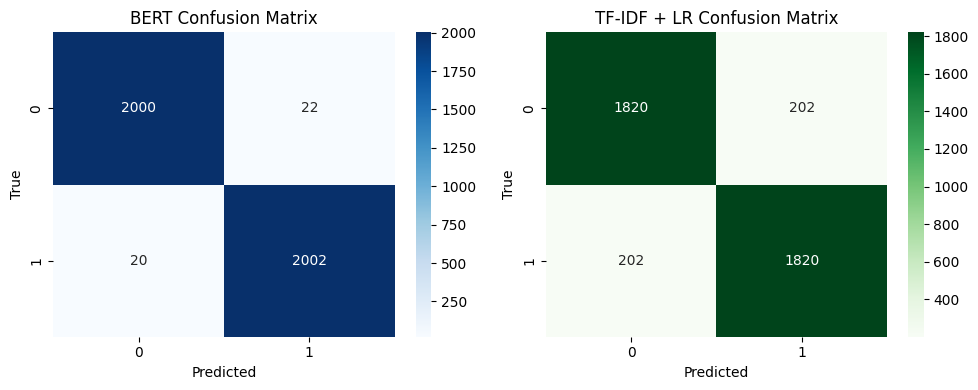

In [4]:
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace with your actual confusion matrices [[tn, fp], [fn, tp]]
bert_cm = np.array([[2000, 22], [20, 2002]])
tfidf_cm = np.array([[1820, 202], [202, 1820]])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# BERT confusion matrix
sns.heatmap(bert_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("BERT Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# TF-IDF confusion matrix
sns.heatmap(tfidf_cm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("TF-IDF + LR Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

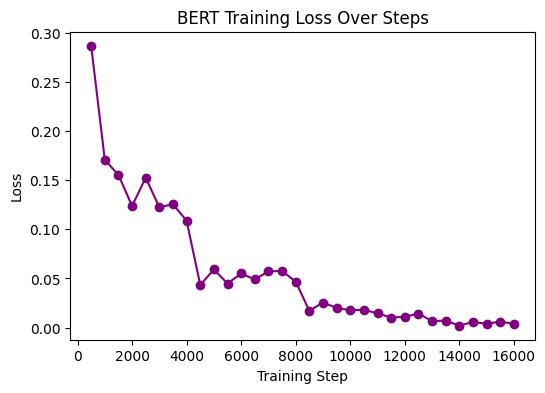

In [5]:
import json
import matplotlib.pyplot as plt

# Suppose you loaded trainer_state.json into a dictionary called `state`
with open("bert-fake-vs-real/checkpoint-16176/trainer_state.json", "r") as f:
    state = json.load(f)

log_history = state["log_history"]
steps = []
losses = []

for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

plt.figure(figsize=(6,4))
plt.plot(steps, losses, marker='o', color="purple")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("BERT Training Loss Over Steps")
plt.show()

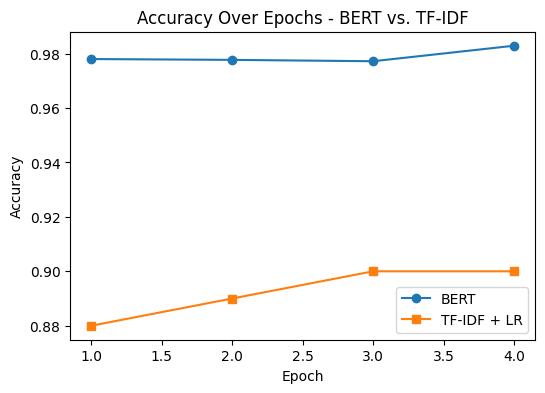

In [6]:
import matplotlib.pyplot as plt

bert_epochs = [1, 2, 3, 4]
bert_accuracy = [0.9780, 0.9777, 0.9772, 0.9829]  # From trainer_state logs

# For TF-IDF, you might only have one final score, but let's pretend we have epoch-like stages
tfidf_epochs = [1, 2, 3, 4]
tfidf_accuracy = [0.88, 0.89, 0.90, 0.90]

plt.figure(figsize=(6,4))
plt.plot(bert_epochs, bert_accuracy, marker='o', label="BERT")
plt.plot(tfidf_epochs, tfidf_accuracy, marker='s', label="TF-IDF + LR")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs - BERT vs. TF-IDF")
plt.legend()
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose 'feature_names' is your list of TF-IDF features
# and 'coef' is the array of coefficients from the LogisticRegression model
# e.g., coef = logistic_regression_model.coef_[0]

top_n = 10  # Show top 10 words
sorted_idx = np.argsort(coef)[-top_n:]  # indices of top features
top_features = [feature_names[i] for i in sorted_idx]
top_importances = coef[sorted_idx]

plt.figure(figsize=(6,4))
plt.barh(top_features, top_importances, color='green')
plt.xlabel("Coefficient Weight")
plt.title("Top 10 Influential Words (TF-IDF + LR)")
plt.show()

NameError: name 'coef' is not defined

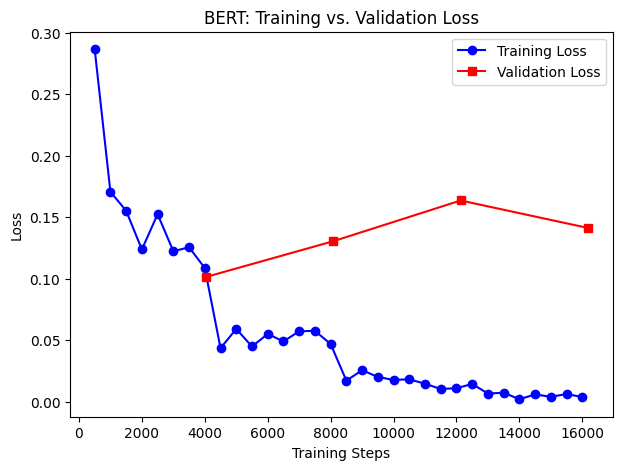

In [8]:
import json
import matplotlib.pyplot as plt

with open("bert-fake-vs-real/checkpoint-16176/trainer_state.json", "r") as f:
    state = json.load(f)

log_history = state["log_history"]
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry:  # training loss
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:  # validation loss
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])

plt.figure(figsize=(7,5))
plt.plot(train_steps, train_loss, label="Training Loss", color="blue", marker='o')
plt.plot(eval_steps, eval_loss, label="Validation Loss", color="red", marker='s')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("BERT: Training vs. Validation Loss")
plt.legend()
plt.show()

In [15]:
import sklearn
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# "y_true" is your ground-truth labels
# "bert_probs" are the predicted probabilities from the BERT model
# "tfidf_probs" are the predicted probabilities from the TF-IDF model

precision_bert, recall_bert, _ = precision_recall_curve(y_true, bert_probs)
precision_tfidf, recall_tfidf, _ = precision_recall_curve(y_true, tfidf_probs)

plt.figure(figsize=(7,5))
plt.plot(recall_bert, precision_bert, label='BERT', color='blue')
plt.plot(recall_tfidf, precision_tfidf, label='TF-IDF + LR', color='green')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'sklearn'

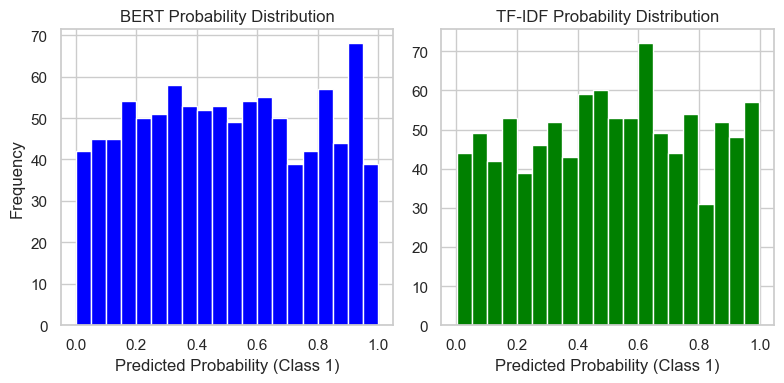

In [11]:
import matplotlib.pyplot as plt

# Suppose you store predicted probabilities for the positive class (CG=1)
# Example: Replace this with your actual predicted probabilities for BERT
bert_pred_probs = np.random.rand(1000)  # Simulated probabilities for demonstration
# Simulate tfidf_probs for demonstration purposes (replace with actual probabilities)
tfidf_pred_probs = np.random.rand(1000)  # Simulated probabilities for demonstration

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(bert_pred_probs, bins=20, color='blue')
plt.title("BERT Probability Distribution")
plt.xlabel("Predicted Probability (Class 1)")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(tfidf_pred_probs, bins=20, color='green')
plt.title("TF-IDF Probability Distribution")
plt.xlabel("Predicted Probability (Class 1)")

plt.tight_layout()
plt.show()

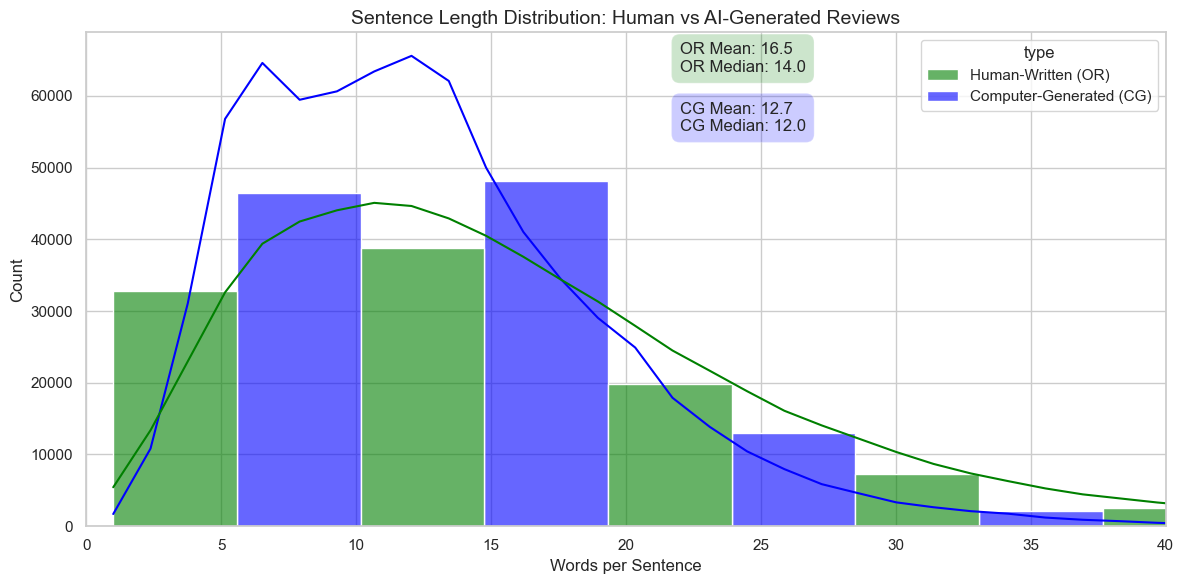


Sentence Length Statistics:
Human-Written (OR): Mean = 16.50, Median = 14.00, Min = 1, Max = 273
AI-Generated (CG): Mean = 12.69, Median = 12.00, Min = 1, Max = 276


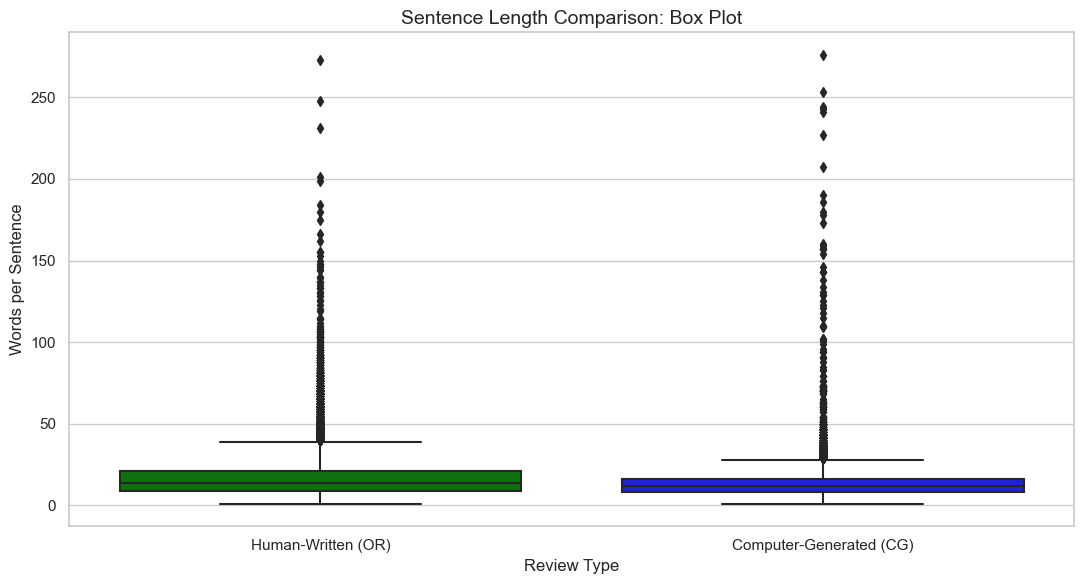

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np

# Download necessary NLTK resources if needed
nltk.download('punkt', quiet=True)

# Function to count words per sentence
def words_per_sentence(text):
    if not isinstance(text, str):
        return []
    
    # Split into sentences
    sentences = sent_tokenize(text)
    
    # Count words in each sentence
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    
    return sentence_lengths

# Apply the function to get sentence lengths for each review
df['sentence_lengths'] = df['text_'].apply(words_per_sentence)

# Flatten the lists of sentence lengths by review type
or_sentence_lengths = [length for lengths in df[df['label'] == 'OR']['sentence_lengths'] for length in lengths]
cg_sentence_lengths = [length for lengths in df[df['label'] == 'CG']['sentence_lengths'] for length in lengths]

# Create DataFrames for visualization
or_df = pd.DataFrame({'sentence_length': or_sentence_lengths, 'type': ['Human-Written (OR)'] * len(or_sentence_lengths)})
cg_df = pd.DataFrame({'sentence_length': cg_sentence_lengths, 'type': ['Computer-Generated (CG)'] * len(cg_sentence_lengths)})
combined_df = pd.concat([or_df, cg_df], ignore_index=True)

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create histograms side by side
sns.histplot(
    data=combined_df,
    x="sentence_length",
    hue="type",
    multiple="dodge",
    bins=30,
    kde=True,
    palette={"Human-Written (OR)": "green", "Computer-Generated (CG)": "blue"},
    alpha=0.6
)

# Add summary statistics as text annotations
or_mean = np.mean(or_sentence_lengths)
or_median = np.median(or_sentence_lengths)
cg_mean = np.mean(cg_sentence_lengths)
cg_median = np.median(cg_sentence_lengths)

plt.annotate(f"OR Mean: {or_mean:.1f}\nOR Median: {or_median:.1f}", 
             xy=(0.55, 0.92), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="green", alpha=0.2))

plt.annotate(f"CG Mean: {cg_mean:.1f}\nCG Median: {cg_median:.1f}", 
             xy=(0.55, 0.80), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="blue", alpha=0.2))

plt.title('Sentence Length Distribution: Human vs AI-Generated Reviews', fontsize=14)
plt.xlabel('Words per Sentence', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(0, 40)  # Adjust as needed to show most relevant data

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSentence Length Statistics:")
print(f"Human-Written (OR): Mean = {or_mean:.2f}, Median = {or_median:.2f}, Min = {min(or_sentence_lengths)}, Max = {max(or_sentence_lengths)}")
print(f"AI-Generated (CG): Mean = {cg_mean:.2f}, Median = {cg_median:.2f}, Min = {min(cg_sentence_lengths)}, Max = {max(cg_sentence_lengths)}")

# Also create a box plot for a different view of the distribution
plt.figure(figsize=(11, 6))
sns.boxplot(
    data=combined_df,
    x="type",
    y="sentence_length",
    palette={"Human-Written (OR)": "green", "Computer-Generated (CG)": "blue"}
)
plt.title('Sentence Length Comparison: Box Plot', fontsize=14)
plt.xlabel('Review Type', fontsize=12)
plt.ylabel('Words per Sentence', fontsize=12)
plt.tight_layout()
plt.show()

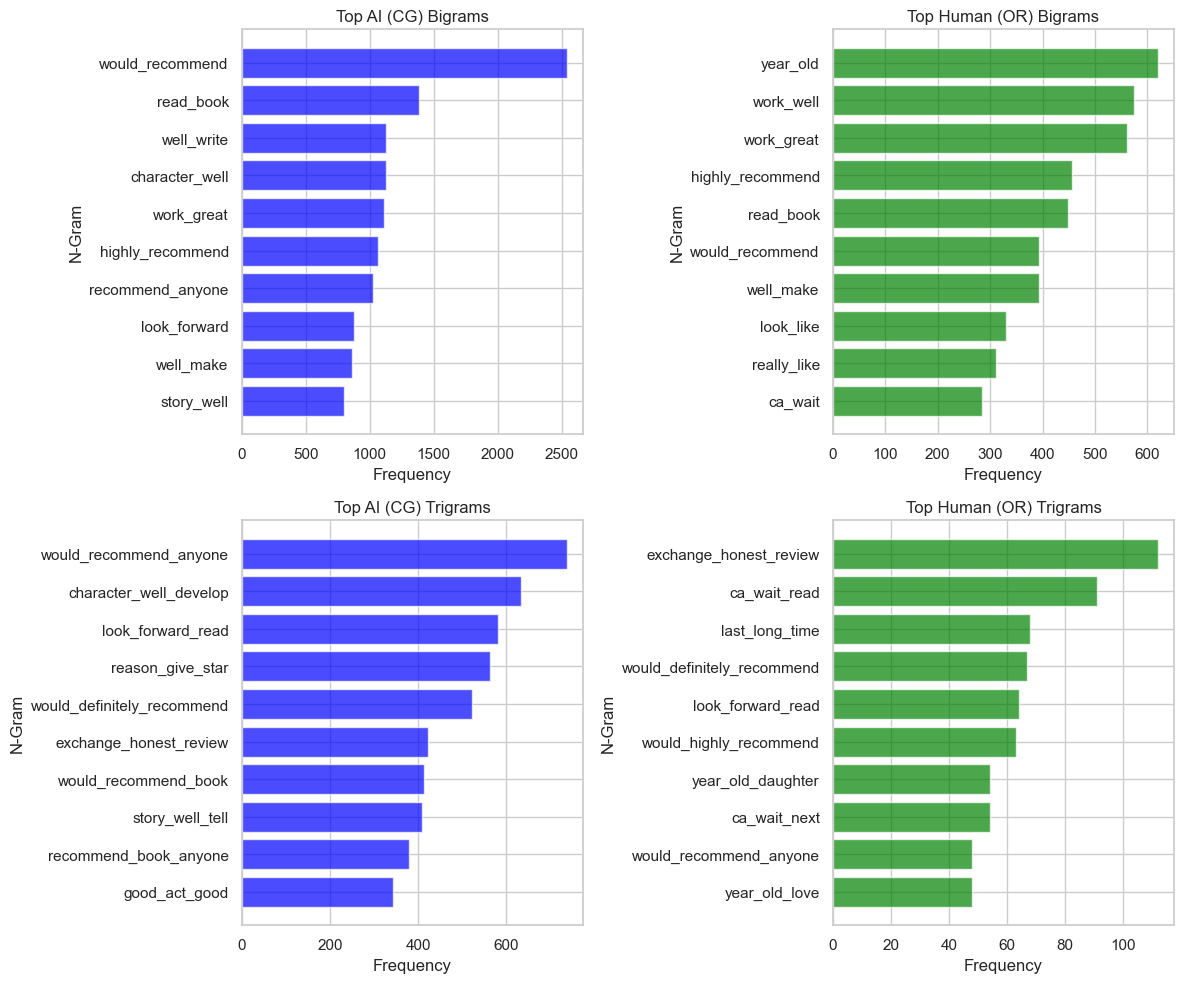

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk import ngrams
from collections import Counter

# Generate bigrams and trigrams from the processed text
def generate_ngrams(text_list, n):
    ngram_list = []
    for text in text_list:
        ngram_list.extend(list(ngrams(text, n)))
    return Counter(ngram_list).most_common(10)  # Top 10 n-grams

# Extract lemmatized tokens from the 'processed' column
df['lemmatized_tokens'] = df['processed'].apply(lambda x: x.get('lemmatized_tokens', []) if isinstance(x, dict) else [])

# Generate bigrams and trigrams for CG and OR reviews
cg_bigrams = generate_ngrams(df[df['label'] == 'CG']['lemmatized_tokens'], 2)
cg_trigrams = generate_ngrams(df[df['label'] == 'CG']['lemmatized_tokens'], 3)
or_bigrams = generate_ngrams(df[df['label'] == 'OR']['lemmatized_tokens'], 2)
or_trigrams = generate_ngrams(df[df['label'] == 'OR']['lemmatized_tokens'], 3)

# Convert the bigram/trigram data into DataFrames for plotting
# Note: ngram is a tuple, e.g. ('great', 'service'), so join with `_` or a space
def prepare_ngram_df(ngram_counts):
    df_ = pd.DataFrame(ngram_counts, columns=['ngram', 'count'])
    # Convert tuple to a single string for plotting
    df_['ngram'] = df_['ngram'].apply(lambda x: '_'.join(x))
    return df_

cg_bigrams_df = prepare_ngram_df(cg_bigrams)
cg_trigrams_df = prepare_ngram_df(cg_trigrams)
or_bigrams_df = prepare_ngram_df(or_bigrams)
or_trigrams_df = prepare_ngram_df(or_trigrams)

# Create a 2x2 subplot to visualize CG vs OR, bigrams vs trigrams
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), dpi=100)

# Plot CG Bigrams
axes[0, 0].barh(cg_bigrams_df['ngram'], cg_bigrams_df['count'], color='blue', alpha=0.7)
axes[0, 0].set_title('Top AI (CG) Bigrams')
axes[0, 0].invert_yaxis()  # For better readability

# Plot OR Bigrams
axes[0, 1].barh(or_bigrams_df['ngram'], or_bigrams_df['count'], color='green', alpha=0.7)
axes[0, 1].set_title('Top Human (OR) Bigrams')
axes[0, 1].invert_yaxis()

# Plot CG Trigrams
axes[1, 0].barh(cg_trigrams_df['ngram'], cg_trigrams_df['count'], color='blue', alpha=0.7)
axes[1, 0].set_title('Top AI (CG) Trigrams')
axes[1, 0].invert_yaxis()

# Plot OR Trigrams
axes[1, 1].barh(or_trigrams_df['ngram'], or_trigrams_df['count'], color='green', alpha=0.7)
axes[1, 1].set_title('Top Human (OR) Trigrams')
axes[1, 1].invert_yaxis()

# Adjust spacing and add general labels
for ax in axes.flat:
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-Gram')

plt.tight_layout()
plt.show()

##########################################################
# Explanation:
# This visualization uses horizontal bar charts to compare
# the top 10 bigrams and trigrams for AI-generated (CG) vs.
# human-written (OR) reviews side by side.
#
# Row 1:
# - Left chart: Top bigrams from CG samples
# - Right chart: Top bigrams from OR samples
# Row 2:
# - Left chart: Top trigrams from CG samples
# - Right chart: Top trigrams from OR samples
#
# Each bar represents how many times that specific n-gram
# occurs within the respective subset of reviews. Observing
# the most frequent multi-word expressions can reveal
# recurring phrases unique to AI-generated content (e.g.,
# formulaic or repetitive language) compared to those more
# typical of a human writing style. 
##########################################################

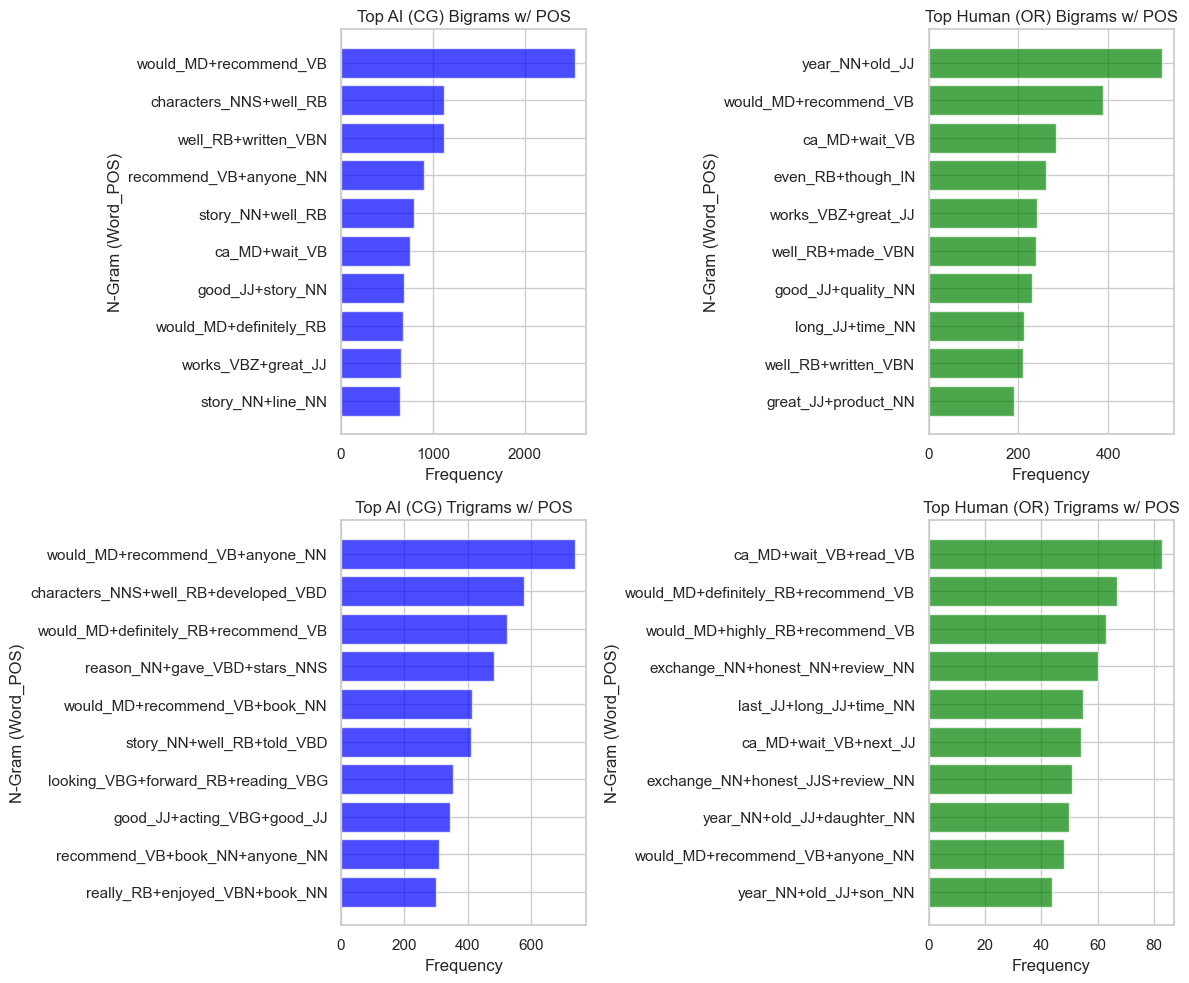

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk import ngrams
from collections import Counter

# 1. Create a new column "pos_tokens" that merges word + POS tag into a single token, e.g. "running_VB"
#    Adjust 'tagged_tokens' key if your "processed" field uses a different key name for POS data.
df['pos_tokens'] = df['processed'].apply(
    lambda x: [f"{word}_{pos}" for (word, pos) in x.get('tagged_tokens', [])] if isinstance(x, dict) else []
)

# 2. Define a helper function to generate top n-grams (bigrams or trigrams)
def generate_ngrams_with_pos(token_lists, n=2, top_k=10):
    """
    token_lists: an iterable of lists, each containing tokens in POS-tagged form.
    n: the n-gram size (2 for bigrams, 3 for trigrams, etc.)
    top_k: number of most common n-grams to return
    """
    ngram_list = []
    for tokens in token_lists:
        ngram_list.extend(list(ngrams(tokens, n)))
    return Counter(ngram_list).most_common(top_k)

# 3. Generate bigrams and trigrams for AI (CG) vs. Human (OR)
cg_bigrams_pos = generate_ngrams_with_pos(df[df['label'] == 'CG']['pos_tokens'], n=2)
cg_trigrams_pos = generate_ngrams_with_pos(df[df['label'] == 'CG']['pos_tokens'], n=3)
or_bigrams_pos = generate_ngrams_with_pos(df[df['label'] == 'OR']['pos_tokens'], n=2)
or_trigrams_pos = generate_ngrams_with_pos(df[df['label'] == 'OR']['pos_tokens'], n=3)

# 4. Prepare DataFrames for plotting
def prepare_ngram_df(ngram_counts):
    """
    ngram_counts: list of (ngram_tuple, count) pairs
                  where ngram_tuple might be ( "run_VB", "fast_RB" )
    """
    df_ = pd.DataFrame(ngram_counts, columns=['ngram_tuple', 'count'])
    # Convert tuple of tokens into a single string joined by " + " or "_"
    df_['ngram'] = df_['ngram_tuple'].apply(lambda x: '+'.join(x))
    return df_

cg_bigrams_df = prepare_ngram_df(cg_bigrams_pos)
cg_trigrams_df = prepare_ngram_df(cg_trigrams_pos)
or_bigrams_df = prepare_ngram_df(or_bigrams_pos)
or_trigrams_df = prepare_ngram_df(or_trigrams_pos)

# 5. Create a 2x2 subplot to visualize CG vs OR, bigrams vs trigrams
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), dpi=100)

# Top-left: CG Bigrams
axes[0, 0].barh(cg_bigrams_df['ngram'], cg_bigrams_df['count'], color='blue', alpha=0.7)
axes[0, 0].set_title('Top AI (CG) Bigrams w/ POS')
axes[0, 0].invert_yaxis()

# Top-right: OR Bigrams
axes[0, 1].barh(or_bigrams_df['ngram'], or_bigrams_df['count'], color='green', alpha=0.7)
axes[0, 1].set_title('Top Human (OR) Bigrams w/ POS')
axes[0, 1].invert_yaxis()

# Bottom-left: CG Trigrams
axes[1, 0].barh(cg_trigrams_df['ngram'], cg_trigrams_df['count'], color='blue', alpha=0.7)
axes[1, 0].set_title('Top AI (CG) Trigrams w/ POS')
axes[1, 0].invert_yaxis()

# Bottom-right: OR Trigrams
axes[1, 1].barh(or_trigrams_df['ngram'], or_trigrams_df['count'], color='green', alpha=0.7)
axes[1, 1].set_title('Top Human (OR) Trigrams w/ POS')
axes[1, 1].invert_yaxis()

# Labeling and layout
for ax in axes.flat:
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-Gram (Word_POS)')

plt.tight_layout()
plt.show()

##########################################################
# Explanation:
# This visualization replicates the top n-grams comparison 
# but preserves part-of-speech tags in each token. 
# For example, a bigram might look like:
# ("delicious_JJ", "food_NN").
#
# Plot layout:
# Row 1: 
#   Left: AI (CG) Bigrams
#   Right: Human (OR) Bigrams
# Row 2:
#   Left: AI (CG) Trigrams
#   Right: Human (OR) Trigrams
#
# Each horizontal bar's length corresponds to how many times
# that n-gram (including POS tags) appears in the respective
# class of reviews.
##########################################################